# Exploring Gibbon with Python
Micah D. Saxton

## Getting started

### Using Google's Colaboratory Notebooks
The webpage you are looking at is an example of a Colab notebook. Notebooks are a convenient way to write and execute Python code. Google's Colab notebooks provide the extra benefit of installing packages and running code on the cloud, rather than on your own CPU.

### First steps:
Navigate to "File" and select "Save a copy in Drive."
Navigate to "Edit", select "Notebook settings" and make sure that "Runtime type" is set to "Python 3."

### Creating code and text cells
Colab notebooks are divided into cells which can contain either text or Python code. Although I have created all the cells we will be using for this workshop, it may be helpful to learn how to add cells of your own.

If you hover your mouse at the top or bottom of an already existing cell, you will have an option of adding a new code or text cell. Additionally, you can select the three dots on the right side of a cell for more options.

### Running code cells
There are two ways to run code cells:

Click the "play" button on the left side of the code cell
Press SHIFT+RETURN (or SHIFT+ENTER)

## Set up
When you code with Python you will often use scripts that other people have written. These are called **libraries**. To use a library you need to install it on you machine, then import it into your code. Most of the libraries we will use here come with Colab Notebooks; we will only need to install ScatterText.

In [3]:
# installations
!pip install scattertext

In [6]:
! pip install spacy

In [8]:
# imports
import nltk
from nltk import word_tokenize
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
nltk.download('punkt')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import spacy
import scattertext as st
from IPython.core.display import HTML

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msaxto01\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msaxto01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\msaxto01\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Create and examine NLTK corpus

### Natural Language Toolkit
The **Natural Language Toolkit** (NLTK) is a library used for natural language processing (NLP). If you want to learn more, I highly recommend working through the [NLTK Book](https://www.nltk.org/book/). This resource is a great introduction to NLP specifically and Python more generally.

In [10]:
# load files as an NLTK corpus
gibbon_corpus = PlaintextCorpusReader('./gibbon/gibbon_decline_and_fall/', '.*\.txt')

In [11]:
# sanity check
print(gibbon_corpus.fileids()[:5])  # Just the first 5

['gibbon_decline_volume1_chap01.txt', 'gibbon_decline_volume1_chap02.txt', 'gibbon_decline_volume1_chap03.txt', 'gibbon_decline_volume1_chap04.txt', 'gibbon_decline_volume1_chap05.txt']


## Pre-process text for analysis
Before doing NLP work, most texts will need to be preprocessed in different ways. You may need to **tokenize** the text, remove stopwords, or **lemmatize** the text. What you do in pre-processing depends entirely on what your project is. 

In [12]:
# create pre_processing function
lemmatizer = WordNetLemmatizer()
def pre_process(doc):
  '''
  This function pre-processes a string by tokenizing it into words, 
  removing stop words and punctuation, and lemmatizing each word.
  It reutrns a list of lemmas.
  '''
  doc_lower = doc.lower()
  tokens = word_tokenize(doc_lower)  # lowercase all words
  tokens_no_stops = [token for token in tokens if not token in stopwords.words('english')]  #remove stop words
  tokens_no_stops_no_punct = [token for token in tokens_no_stops if token.isalpha()]  # remove punctuation
  lemmas = []
  for token in tokens_no_stops_no_punct:
    lemma = lemmatizer.lemmatize(token)
    lemmas.append(lemma)
  return lemmas

In [ ]:
# This will take about 5 minutes
gibbon_docs = []
for fileid in gibbon_corpus.fileids():
  raw_text = gibbon_corpus.raw(fileid)
  lemmas = pre_process(raw_text)
  gibbon_docs.append(lemmas)

In [ ]:
# Sanity check
print(len(gibbon_docs))
print(gibbon_docs[0])

71
['extent', 'military', 'force', 'roman', 'empire', 'age', 'antonines', 'introduction', 'second', 'century', 'christian', 'era', 'empire', 'rome', 'comprehended', 'fairest', 'part', 'earth', 'civilised', 'portion', 'mankind', 'frontier', 'extensive', 'monarchy', 'guarded', 'ancient', 'renown', 'disciplined', 'valour', 'gentle', 'powerful', 'influence', 'law', 'manner', 'gradually', 'cemented', 'union', 'province', 'peaceful', 'inhabitant', 'enjoyed', 'abused', 'advantage', 'wealth', 'luxury', 'image', 'free', 'constitution', 'preserved', 'decent', 'reverence', 'roman', 'senate', 'appeared', 'posse', 'sovereign', 'authority', 'devolved', 'emperor', 'executive', 'power', 'government', 'happy', 'period', 'fourscore', 'year', 'public', 'administration', 'conducted', 'virtue', 'ability', 'nerva', 'trajan', 'hadrian', 'two', 'antonines', 'design', 'two', 'succeeding', 'chapter', 'describe', 'prosperous', 'condition', 'empire', 'afterwards', 'death', 'marcus', 'antoninus', 'deduce', 'import

## Find the most important words by chapter in Gibbon
For this part we are going to use a library called [scikit-learn](https://scikit-learn.org/stable/). This library is primarily for machine learning, but many of its features are useful for DH work.

In [ ]:
# The tool I will use here requires a string as input rather than a list, so I convert my docs from lists to strings
gibbon_doc_strings = []
for doc in gibbon_docs:
  string = ' '.join(doc)
  gibbon_doc_strings.append(string)


In [ ]:
# transform corpus into a matrix of word counts
vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, 
                             use_idf= True, norm=None)
transformed_docs = vectorizer.fit_transform(gibbon_doc_strings)
transformed_docs_as_array = transformed_docs.toarray()

In [ ]:
gibbon_key_vocab_by_chap = {}
for doc, fileid in zip(transformed_docs_as_array, gibbon_corpus.fileids()):
  tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
  sorted_tf_idf_tuples = sorted(tf_idf_tuples, key= lambda x: x[1], reverse=True)
  k = fileid[23:29]
  v = sorted_tf_idf_tuples[:10]
  gibbon_key_vocab_by_chap[k] = v

In [ ]:
for k, v in gibbon_key_vocab_by_chap.items():
  result = k + ' => ' + v[0][0] + ', ' + v[1][0] + ', ' + v[2][0] + ', ' + v[3][0] + ', ' + v[4][0]
  print(result)

chap01 => hadrian, trajan, antoninus, mediterranean, antonines
chap02 => atticus, antonines, herod, gaul, athens
chap03 => hadrian, caligula, domitian, tribunitian, adoption
chap04 => commodus, pertinax, cleander, marcus, perennis
chap05 => severus, niger, albinus, pertinax, praetorian
chap06 => caracalla, macrinus, elagabalus, severus, alexander
chap07 => maximin, gordian, gordians, balbinus, maximus
chap08 => artaxerxes, parthian, zoroaster, persia, seleucia
chap09 => tacitus, rhine, warrior, reindeer, iron
chap10 => goth, valerian, gallienus, decius, sapor
chap11 => aurelian, zenobia, claudius, palmyra, tetricus
chap12 => probus, carus, carinus, tacitus, aurelian
chap13 => diocletian, maximian, galerius, tiridates, carausius
chap14 => licinius, maxentius, galerius, maximian, maximin
chap15 => christianity, primitive, jew, doctrine, gentile
chap16 => persecution, galerius, edict, diocletian, cyprian
chap17 => praefects, byzantium, capitation, praetorian, indiction
chap18 => constanti

In [ ]:
# explore vocabulary
gibbon_key_vocab_by_chap['chap16']  # <-- you can investigate other chapters

[('persecution', 155.43864657400138),
 ('galerius', 121.49453393877634),
 ('edict', 110.04987891204898),
 ('diocletian', 107.00509529568842),
 ('cyprian', 104.70101241711441),
 ('martyr', 101.46903778032578),
 ('maximin', 80.06548008367572),
 ('martyrdom', 67.51687454474039),
 ('sect', 63.01100139839618),
 ('christianity', 57.160319936476284)]

## Conditional frequency distribution in Gibbon
A **conditional frequency distribution** (cfd) is a collection of word counts for a given condition, i.e. category. Here the category is separate chapters in Gibbon. We can chart what used are used most frequently by chapter. This will tell us something about the nature of each chapter.

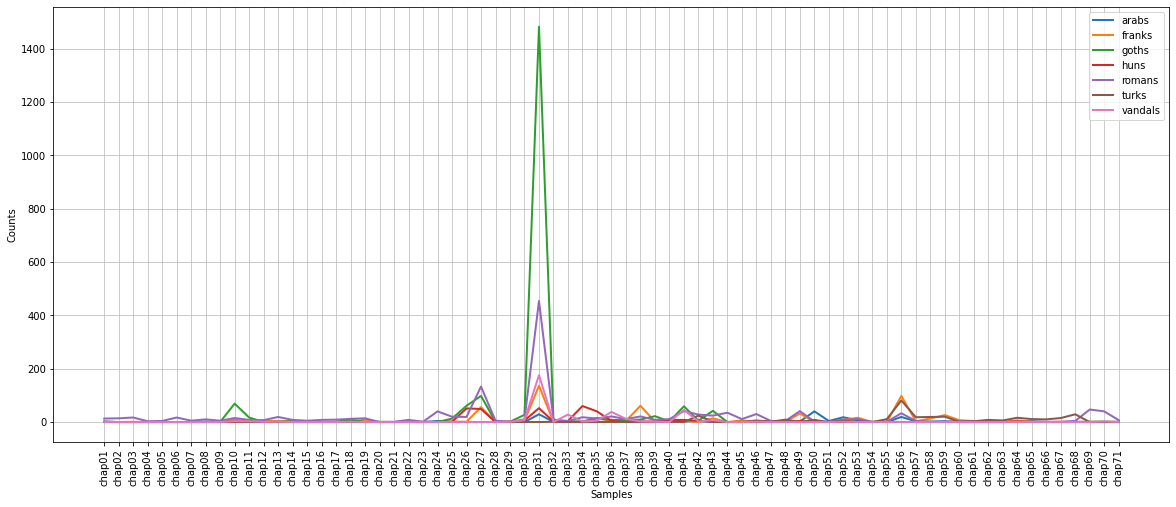

In [ ]:
# conditional frequency distribution
cfd = nltk.ConditionalFreqDist(
    (target, fileid[23:29])  # just display the chapter (i.e. "chap01")
    for fileid in gibbon_corpus.fileids()
    for word in gibbon_corpus.words(fileid)
    for target in ['romans', 'franks', 'huns', 'goths', 'vandals', 'arabs', 'turks',]  # <-- instert token(s) to explore (lowercase)
    if word.lower().startswith(target)
)
# display plot
plt.figure(figsize=(20, 8))  # this expands the plot to make it more readable
cfd.plot()

### Activity
Based on the key vocabulary by chapter above, explore the use of different terms in the conditional frequency distribution. 
* What questions about the text does this raise for you?
* What hypotheses about the text can you form?

## ScatterText
[ScatterText](https://github.com/JasonKessler/scattertext) is a python library used to visually compare texts according to two categories.

**Technical note**: Due to the large corpora we will be comparing, I have made adjustments to [spaCy](https://spacy.io/) to reduce processing time.

In [ ]:
nlp = spacy.load('en')
nlp.max_length=2000000
nlp.disable_pipes('ner', 'tagger')

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fef08f929f0>),
 ('tagger', <spacy.pipeline.pipes.Tagger at 0x7fef08970d50>)]

### Compare Gibbon's first and last volume

In [ ]:
vol_1 = []
for doc in gibbon_doc_strings[:16]:  # remeber: final number of a slice is exclusive
  vol_1.append(doc)

vol_6 = []
for doc in gibbon_doc_strings[57:]:
  vol_6.append(doc)


**Note**: ScatterText requires data in a [Pandas](https://pandas.pydata.org/docs/#) dataframe.

In [ ]:
vol_1_df = pd.DataFrame(data={'volume': 'volume 1', 'text': vol_1})
vol_6_df = pd.DataFrame(data={'volume': 'volume 2', 'text': vol_6})
df = vol_1_df.append(vol_6_df)

In [ ]:
corpus = st.CorpusFromPandas(df, category_col='volume', text_col='text').build()

In [ ]:
html = st.produce_scattertext_explorer(corpus, category='volume 1',
                                       category_name='volume 1',
                                       not_category_name='volume 6',
                                       width_in_pixels=900)
HTML(html)

In [ ]:
# download interactive html
with open('./scattertext.html', encoding='utf8', mode='w') as f:
  f.write(html)
files.download('./scattertext.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Compare Gibbon and Hume

### Prepare Hume text

In [ ]:
hume_corpus = PlaintextCorpusReader('./18th-century-historians/hume/hume-history-of-england/', '.*\.txt')
print(hume_corpus.fileids()[:5])  # Just the first 5

['hume_history_chap01.txt', 'hume_history_chap02.txt', 'hume_history_chap03.txt', 'hume_history_chap03_app01.txt', 'hume_history_chap04.txt']


In [ ]:
# This will take about 3 minutes
hume_docs = []
for fileid in hume_corpus.fileids():
  raw_text = hume_corpus.raw(fileid)
  lemmas = pre_process(raw_text)
  hume_docs.append(lemmas)

In [ ]:
hume_doc_strings = []
for doc in hume_docs:
  string = ' '.join(doc)
  hume_doc_strings.append(string)

In [ ]:
gibbon_df = pd.DataFrame(data={'author': 'Gibbon', 'text': gibbon_doc_strings})
hume_df = pd.DataFrame(data={'author': 'Hume', 'text': hume_doc_strings})
author_df = gibbon_df.append(hume_df)

In [ ]:
# about 3 min
author_corpus = st.CorpusFromPandas(author_df,
                                    category_col='author',
                                    text_col='text',
                                    nlp=nlp,
                                    ).build()

In [ ]:
html = st.produce_scattertext_explorer(author_corpus, category='Gibbon',
                                       category_name='Gibbon',
                                       not_category_name='Hume',
                                       width_in_pixels=900)
HTML(html)